## Packages

In [123]:
# primary EDA code
import pandas as pd
import numpy as np
import os
import random

# packages for plots
import matplotlib.pyplot as plt
import seaborn as sns

# warning ignore
import warnings
warnings.filterwarnings("ignore")

# packages for fft
import spectrum
from spectrum import Periodogram

# packages for ML
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold

## Data Import

In [88]:
def data_import(folder_path):
    df_gp = pd.DataFrame()
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
            stock = filename[0:4]
            #print("Loading stock data:", stock, ",")
            try:
                temp_df = pd.read_csv(os.path.join(folder_path, filename), delimiter= '\s+', header = None)
                temp_df.rename(columns={123:'rtn'}, inplace=True)
                temp_df = pd.concat([pd.Series([stock] * temp_df.shape[0], name = 'stock'), temp_df], axis=1)
                temp_df = temp_df.iloc[21:,:]
                df_gp = pd.concat([df_gp, temp_df])
                continue
            except:
                print('The following file cannot be read: ' + folder_path + filename)
        else:
            continue
            
    # Drop NaN values
    df_gp = df_gp.dropna()
    
    # Set all columns except stock names to numerics
    for col in df_gp.columns:
        if col != 'stock':
            df_gp[col] = pd.to_numeric(df_gp[col],errors='coerce')
            
    # Rename the columns
    osc_headers = []
    stk_headers = []
    macd_headers = []
    for i in range(41):
        osc_headers.append('osc' + str(i))
        stk_headers.append('stk' + str(i))
        macd_headers.append('macd' + str(i))
    df_gp.columns = ['stock'] + osc_headers + stk_headers + macd_headers + ['rtn']
    
    # Reset index
    df_gp = df_gp.reset_index(drop=True)

    return df_gp

In [89]:
df_buy_gp = data_import('data/buy/')

## Data Organize

In [91]:
def data_organize(df_gp):
    try:
        name_gp = df_gp.iloc[:, 0]
        osc_gp = df_gp.iloc[:, 1:42]
        stk_gp = df_gp.iloc[:, 42:83]
        macd_gp = df_gp.iloc[:, 83:124]
        rtn_gp = df_gp.iloc[:, 124]
        label_gp = np.sign(rtn_gp).map({1: 1, -1: 0, 0:0})
        results_gp = label_gp.map({1: 'EARN', 0: 'LOSS'})
    except:
        print('Please check the dataframe index')

    return name_gp, osc_gp, stk_gp, macd_gp, rtn_gp, label_gp, results_gp

In [92]:
name_gp, osc_gp, stk_gp, macd_gp, rtn_gp, label_gp, results_gp = data_organize(df_buy_gp)

## Feature Engineering

In [95]:
def smooth_generator(data):
    smooth_list = []
    for i in range(data.shape[0]):
        smooth_list.append(np.var(np.diff(data.iloc[i,:])))
    smooth = pd.DataFrame(smooth_list, columns=["smooth"])

    return smooth

def derivative(data, space = 1, name = "macd"):
    dy = []
    for i in range(data.shape[0]):
        y = pd.Series(data.iloc[i,:])
        temp_dy = list(np.gradient(y, space))
        dy.append(temp_dy)

    col_name = []
    for i in range(data.shape[1]):
        col_name.append(name + "deriv"+ str(i))

    deriv_df = pd.DataFrame(dy, columns=col_name)

    return deriv_df

def psd_generator(data, NFFT = 100, name = "osc"):
    freq = []
    for i in range(data.shape[0]):
        data_osc = data.iloc[i,:]
        p = Periodogram(data_osc, NFFT=NFFT)
        temp_list = list(p.psd)
        freq.append(temp_list)
    col_name = []
    for i in range(int(NFFT/2)+1):
        col_name.append("psd"+str(i))

    psd_df = pd.DataFrame(freq, columns=col_name)
    return psd_df

def volatility(data):
    vol = []
    for i in range(data.shape[0]):
        vol.append(np.var(data.iloc[i,:]))
    vol = pd.DataFrame(vol, columns=["volatility"])
    return vol

def amplitude(data):
    amp = []
    for i in range(data.shape[0]):
        amp.append(np.var(np.diff(data.iloc[i,:]))/(np.mean(abs(data.iloc[i,:]))))
    amp = pd.DataFrame(amp, columns=["amplitude"])
    return amp

In [96]:
# Factor for smoothness
smooth_osc = smooth_generator(osc_gp)
# calculate the dy for macd
first_deriv_macd = derivative(macd_gp, name="macd_1st")    
# calculate the ddy for macd
second_deriv_macd = derivative(first_deriv_macd, name="macd_2nd") 
# calculate the dy for osc
first_deriv_osc = derivative(osc_gp, name="osc_1st")
# calculate the dy for stock
first_deriv_stk = derivative(stk_gp, name="stk_1st")
# calculate the volatility for stock
vol_stk = volatility(stk_gp)
# calculate the amplitude with its ratio
amp_osc = amplitude(osc_gp)
amp_smooth_osc = pd.DataFrame()
amp_smooth_osc['ratio'] = smooth_osc['smooth']/amp_osc['amplitude']
# calcuate the psd
psd_osc = psd_generator(osc_gp)

## Split Train and Test Sets (with rtn)

In [97]:
Feature_matrix_w_rtn = pd.concat([rtn_gp, smooth_osc, first_deriv_macd, second_deriv_macd, first_deriv_osc, first_deriv_stk, vol_stk, amp_smooth_osc, psd_osc], axis=1)

# Split test set
X_w_rtn, X_test_w_rtn, y, y_test = train_test_split(Feature_matrix_w_rtn, label_gp, test_size=0.2)

## Random Forest Classifier

In [99]:
def random_forest_classifier(X_w_rtn, y, test_size=0.2, cv=2):
    
    results_summaries_collection = pd.DataFrame()
    results_prob_summaries_collection = pd.DataFrame()
    
    # n-fold Cross Validation
    kf = KFold(n_splits=cv)
    kf.get_n_splits(X_w_rtn)

    # Within each fold
    for train_index, valid_index in kf.split(X_w_rtn):
        # Define train/ validation set (convert X_w_rtn and y to np.array for indexing on the next line)
        X_train_w_rtn, X_valid_w_rtn = X_w_rtn.values[train_index], X_w_rtn.values[valid_index]
        y_train, y_valid = y.values[train_index], y.values[valid_index]
    
        # Separate returns from Feature matrix (convert X_w_rtn and y back to pandas)
        X_train = pd.DataFrame(X_train_w_rtn).iloc[:, 1:]
        X_valid = pd.DataFrame(X_valid_w_rtn).iloc[:, 1:]

        rtn_train = pd.DataFrame(X_train_w_rtn).iloc[:, 0]
        rtn_valid = pd.DataFrame(X_valid_w_rtn).iloc[:, 0]
    
        y_train = pd.Series(y_train)
        y_valid = pd.Series(y_valid)
    
        # Reset indices on all
        X_train = X_train.reset_index(drop=True)
        y_train = y_train.reset_index(drop=True)
        rtn_train = rtn_train.reset_index(drop=True)

        X_valid = X_valid.reset_index(drop=True)
        y_valid = y_valid.reset_index(drop=True)
        rtn_valid = rtn_valid.reset_index(drop=True)

        # Fit Random Forest
        rf = RandomForestClassifier()
        rf.fit(X_train, y_train)

        # Extracts the probabilities of being a good trade
        log_proba_set_valid = rf.predict_log_proba(X_valid)
        proba_valid = []
        for prob in range(len(log_proba_set_valid)):
            proba_valid.append(np.exp(log_proba_set_valid[prob][1]))

        # Get probabilities summary table
        results_prob = pd.concat([pd.DataFrame(proba_valid), y_valid, rtn_valid], axis =1)
        results_prob.columns = ['prob', 'label', 'return']
        results_prob['prob'] = np.round(results_prob['prob'],1)

        results_prob_summary = pd.concat([results_prob.groupby(['prob']).mean()['label'], results_prob.groupby(['prob']).count()['label'], results_prob.groupby(['prob']).mean()['return']],axis=1)
        results_prob_summary.columns = ['WinRate', 'Count', 'Avg. Return']
        results_prob_summary['% of All Trades'] = np.round(results_prob_summary['Count']/np.sum(results_prob_summary['Count']),4)*100

        # Classify the Classes of the Trades
        # Proba 1.0 => Excellent
        # Proba 0.8 - 1.0 => Great
        # Proba 0.6 - 0.8 => Good
        # Proba 0.0 - 0.6 => Average
        # Proba 0.0 => Sell
    
        trade_classes = ['Sell'] * len(proba_valid)
        for i in range(len(proba_valid)):
            if proba_valid[i] == 1.0:
                trade_classes[i] = 'Excellent'
            elif proba_valid[i] > 0.8:
                trade_classes[i] = 'Great'
            elif proba_valid[i] > 0.6:
                trade_classes[i] = 'Good'
            elif proba_valid[i] > 0.0:
                trade_classes[i] = 'Average'

        # Put Results Together
        results = pd.concat([pd.DataFrame(proba_valid), pd.DataFrame(trade_classes), y_valid, rtn_valid], axis =1)
        results.columns = ['prob', 'trade_class', 'label', 'return']

        # Make Results Summary
        results_summary = pd.concat([results.groupby(['trade_class']).mean()['label'], results.groupby(['trade_class']).count()['label'], results.groupby(['trade_class']).mean()['return']],axis=1)
        results_summary.columns = ['WinRate', 'Count', 'Avg. Return']
        results_summary['% of All Trades'] = np.round(results_summary['Count']/np.sum(results_summary['Count']),4)*100

        # Store it in the Results Collection
        results_prob_summaries_collection = pd.concat([results_prob_summaries_collection, results_prob_summary])
        results_summaries_collection = pd.concat([results_summaries_collection, results_summary])
    
    results_summaries_collection = results_summaries_collection.groupby(['trade_class']).mean().reindex(['Excellent', 'Great', 'Good', 'Average', 'Sell'])
    results_prob_summaries_collection = results_prob_summaries_collection.groupby(['prob']).mean()
    
    return rf, results_prob_summaries_collection, results_summaries_collection


In [100]:
rf, results_prob_summaries_collection, results_summaries_collection = random_forest_classifier(X_w_rtn, y)

In [101]:
results_prob_summaries_collection

,WinRate,Count,Avg. Return,% of All Trades
prob,,,,
0.0,0.207547,471.5,-0.277722,1.120
0.1,0.355565,1656.5,-0.056952,3.935
0.2,0.387491,4425.5,-0.001048,10.520
0.3,0.395773,7905.0,0.009105,18.785
0.4,0.406635,9890.5,0.030833,23.510
0.5,0.417768,8774.5,0.077269,20.855
0.6,0.417171,5459.5,0.069438,12.975
0.7,0.435606,2416.0,0.108861,5.740
0.8,0.525873,776.5,0.299754,1.845


In [102]:
results_summaries_collection

,WinRate,Count,Avg. Return,% of All Trades
trade_class,,,,
Excellent,0.956250,80.0,1.540312,0.19
Great,0.666225,219.5,0.667306,0.52
Good,0.457426,3194.0,0.154871,7.59
Average,0.403761,38136.5,0.034998,90.64
Sell,0.221320,445.0,-0.278488,1.06


In [132]:
# Check feature importance
fi_summary = pd.DataFrame({'Features': X_w_rtn.iloc[:, 1:].columns, 
                           'Feature_Importances': rf.feature_importances_})
fi_summary = fi_summary.sort_values('Feature_Importances', ascending = False)
fi_summary.head(20)

,Features,Feature_Importances
165,volatility,0.006301
206,psd39,0.006195
213,psd46,0.006129
204,psd37,0.006097
176,psd9,0.006072
200,psd33,0.005946
179,psd12,0.005854
194,psd27,0.005842
216,psd49,0.005821
199,psd32,0.005611


## Test Set

In [128]:
# Separate returns from Feature matrix
X_test = X_test_w_rtn.iloc[:, 1:]
rtn_test = X_test_w_rtn.iloc[:, 0]

# Reset Indices on All
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
rtn_test = rtn_test.reset_index(drop=True)

# Extracts the probabilities of being a good trade
log_proba_set_test = rf.predict_log_proba(X_test)
proba_test = []
for prob in range(len(log_proba_set_test)):
    proba_test.append(np.exp(log_proba_set_test[prob][1]))

    
# Classify the Classes of the Trades
trade_classes_test = ['Sell'] * len(proba_test)
for i in range(len(proba_test)):
    if proba_test[i] == 1.0:
        trade_classes_test[i] = 'Excellent'
    elif proba_test[i] > 0.8:
        trade_classes_test[i] = 'Great'
    elif proba_test[i] > 0.6:
        trade_classes_test[i] = 'Good'
    elif proba_test[i] > 0.0:
        trade_classes_test[i] = 'Average'
    
# Put Test Set and its Results Together
test_results = pd.concat([pd.DataFrame(proba_test), pd.DataFrame(trade_classes_test), y_test, rtn_test], axis =1)
test_results.columns = ['prob', 'trade_class', 'label', 'return']
test_summary = pd.concat([X_test, test_results], axis =1)

# Make Results Summary
test_results_summary = pd.concat([test_results.groupby(['trade_class']).mean()['label'], test_results.groupby(['trade_class']).count()['label'], test_results.groupby(['trade_class']).mean()['return']],axis=1)
test_results_summary.columns = ['WinRate', 'Count', 'Avg. Return']
test_results_summary['% of All Trades'] = np.round(test_results_summary['Count']/np.sum(test_results_summary['Count']),4)*100
test_results_summary.reindex(['Excellent', 'Great', 'Good', 'Average', 'Sell'])


,WinRate,Count,Avg. Return,% of All Trades
trade_class,,,,
Excellent,0.937500,32,2.277500,0.15
Great,0.660550,109,0.522294,0.52
Good,0.467069,1655,0.105801,7.87
Average,0.406616,19045,0.065977,90.53
Sell,0.269036,197,-0.336142,0.94


In [130]:
def EDA_Model(index, result_df, osc_ind = True, stk_ind = True, macd_ind = True, style = 'bmh', figsize=(7,7)):
    
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        num_layout = np.sum([osc_ind, stk_ind, macd_ind])
        layout = (num_layout, 1)
        
        select = result_df.iloc[index,:]
        #print(select[0:41])

        if osc_ind:
            osc_ax = plt.subplot2grid(layout, (0, 0))
            osc_ax.plot(range(41), select[0:41])
            osc_ax.invert_xaxis()
            osc_ax.set_title('Oscillator 3-Day Time Series')
            osc_ax.set_xlabel('Time')
            osc_ax.set_ylabel('Oscillator')
        
        if stk_ind:
            stk_ax = plt.subplot2grid(layout, (1, 0))
            stk_ax.plot(range(41), select[41:82])
            stk_ax.invert_xaxis()
            stk_ax.set_title('Stock Price 3-Day Time Series')
            stk_ax.set_xlabel('Time')
            stk_ax.set_ylabel('Stock Price')
        
        if macd_ind:
            macd_ax = plt.subplot2grid(layout, (2, 0))
            macd_ax.plot(range(41), select[82:123])
            macd_ax.invert_xaxis()
            macd_ax.set_title('MACD 3-Day Time Series')
            macd_ax.set_xlabel('Time')
            macd_ax.set_ylabel('MACD')
        
        
        plt.tight_layout()

Model Rating: Average
Log Prob: 0.4
Actual Return: 0.23


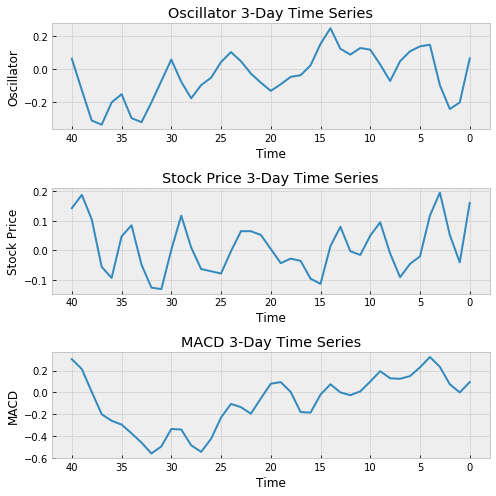

In [135]:
# Plot basic EDA
index = random.randint(0,len(test_summary))
EDA_Model(index, test_summary)
print('Model Rating: ' + str(test_summary.trade_class[index]))
print('Log Prob: ' + str(test_summary.prob[index]))
if test_summary.label[index] == 1:
    TCOL =  '\033[1;32m' # Green Text 
else:
    TCOL = '\033[1;31m' # Red Text
print(TCOL + 'Actual Return: ' + str(test_summary['return'][index]))